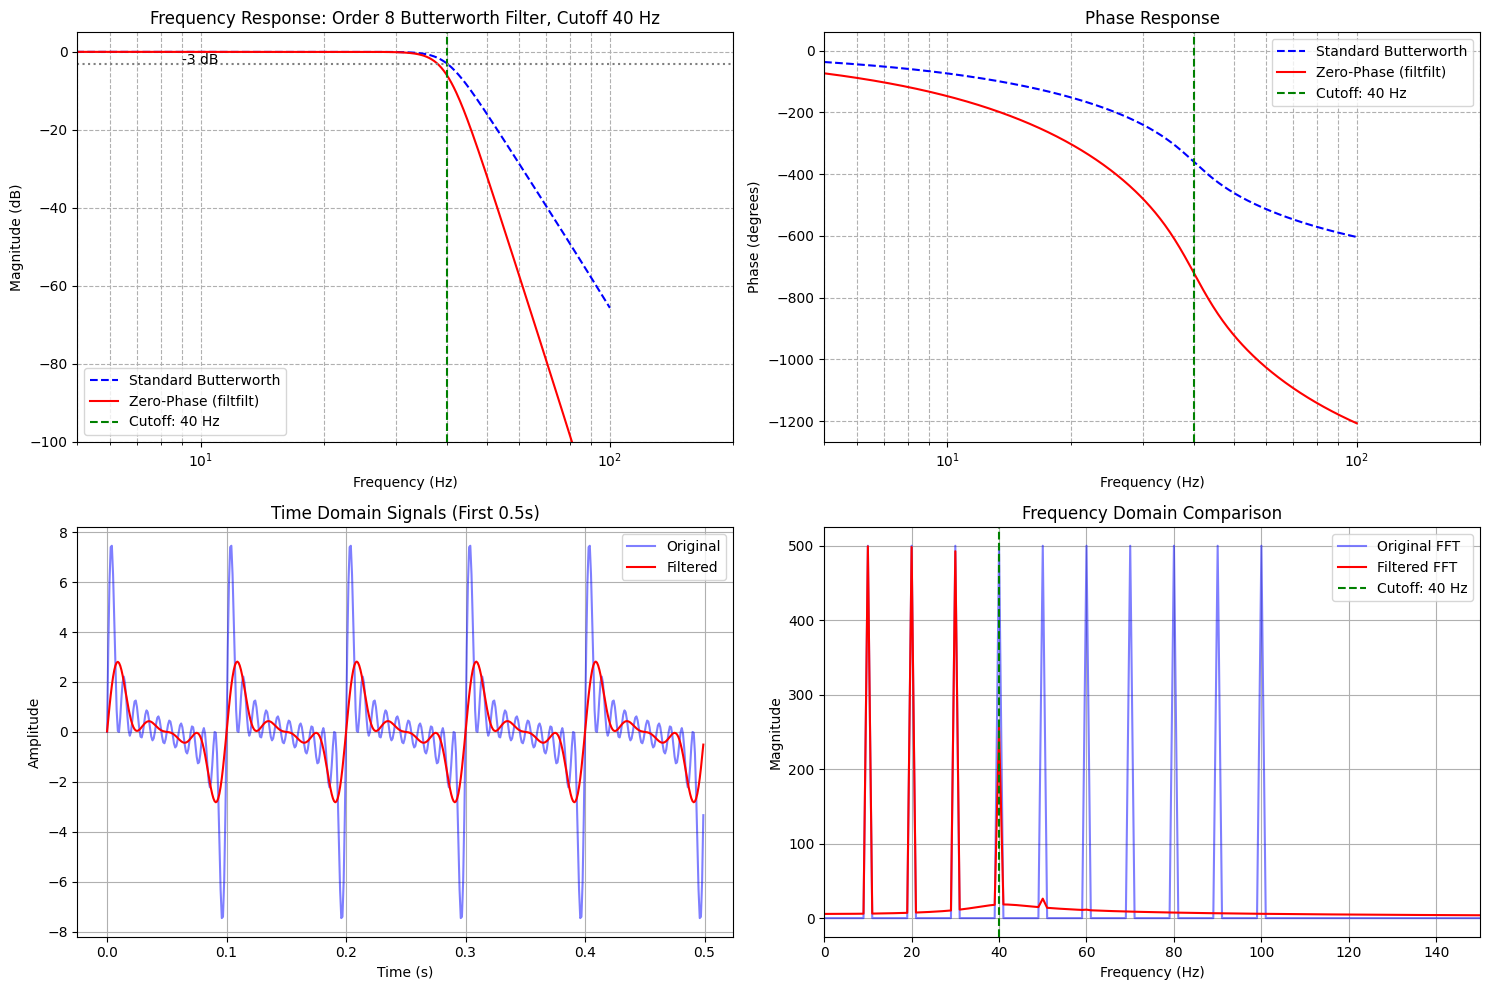

Attenuation at different frequencies using zero-phase filtering:
Frequency (Hz) | Attenuation (dB)
---------------|----------------
           10 |            0.00
           20 |           -0.00
           30 |           -0.11
           40 |           -6.02
           50 |          -28.22
           60 |          -30.98
           70 |          -29.60
           80 |          -28.40
           90 |          -27.39
          100 |          -26.52


In [3]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# Define filter parameters
order = 8
cutoff_freq = 40  # Hz
fs = 1000  # Sampling frequency (Hz)
nyquist = 0.5 * fs

# Normalize the cutoff frequency
normalized_cutoff = cutoff_freq / nyquist

# Create the Butterworth filter
b, a = signal.butter(order, normalized_cutoff, btype='low', analog=False)

# Generate frequency response
worN = np.logspace(-1, 2, 1000)  # Logarithmically spaced frequencies
w, h = signal.freqz(b, a, worN=worN*np.pi/nyquist)
frequencies = w * nyquist / np.pi  # Convert to Hz

# Calculate the zero-phase (filtfilt) frequency response
# For filtfilt, the effective order is doubled
# Create two identical filters (forward and backward pass)
z1, p1, k1 = signal.butter(order, normalized_cutoff, btype='low', analog=False, output='zpk')
z2, p2, k2 = signal.butter(order, normalized_cutoff, btype='low', analog=False, output='zpk')

# Combine the zeros, poles, and gain for forward and backward passes
z_combined = np.concatenate((z1, z2))
p_combined = np.concatenate((p1, p2))
k_combined = k1 * k2

# Calculate frequency response of the combined filter
w_zp, h_zp = signal.freqz_zpk(z_combined, p_combined, k_combined, worN=worN*np.pi/nyquist)
frequencies_zp = w_zp * nyquist / np.pi

# Create a sample signal with frequencies from 10 to 100 Hz
t = np.arange(0, 1, 1/fs)  # 1 second at 1000 Hz sampling
signal_components = []
test_freqs = np.arange(10, 101, 10)  # Test frequencies: 10, 20, ..., 100 Hz

for freq in test_freqs:
    signal_components.append(np.sin(2 * np.pi * freq * t))

# Sum all components with equal amplitude
x = np.sum(signal_components, axis=0)

# Apply standard filtfilt for zero-phase filtering
x_filtered = signal.filtfilt(b, a, x)

# Compute FFT of original and filtered signals
fft_x = np.abs(np.fft.rfft(x))
fft_x_filtered = np.abs(np.fft.rfft(x_filtered))
freq_bins = np.fft.rfftfreq(len(x), 1/fs)

# Plot the results
plt.figure(figsize=(15, 10))

# Plot 1: Frequency response of the filter
plt.subplot(2, 2, 1)
plt.semilogx(frequencies, 20 * np.log10(abs(h)), 'b--', label='Standard Butterworth')
plt.semilogx(frequencies_zp, 20 * np.log10(abs(h_zp)), 'r-', label='Zero-Phase (filtfilt)')
plt.axvline(cutoff_freq, color='green', linestyle='--', label='Cutoff: 40 Hz')
plt.grid(True, which='both', ls='--')
plt.axhline(-3, color='gray', linestyle=':')
plt.text(10, -4, '-3 dB', va='bottom', ha='center')
plt.title(f'Frequency Response: Order {order} Butterworth Filter, Cutoff {cutoff_freq} Hz')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.legend()
plt.xlim(5, 200)
plt.ylim(-100, 5)

# Plot 2: Phase response
plt.subplot(2, 2, 2)
plt.semilogx(frequencies, np.unwrap(np.angle(h))*180/np.pi, 'b--', label='Standard Butterworth')
plt.semilogx(frequencies_zp, np.unwrap(np.angle(h_zp))*180/np.pi, 'r-', label='Zero-Phase (filtfilt)')
plt.axvline(cutoff_freq, color='green', linestyle='--', label='Cutoff: 40 Hz')
plt.grid(True, which='both', ls='--')
plt.title('Phase Response')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase (degrees)')
plt.legend()
plt.xlim(5, 200)

# Plot 3: Original and filtered signals in time domain
plt.subplot(2, 2, 3)
plt.plot(t[:500], x[:500], 'b-', alpha=0.5, label='Original')
plt.plot(t[:500], x_filtered[:500], 'r-', label='Filtered')
plt.grid(True)
plt.title('Time Domain Signals (First 0.5s)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()

# Plot 4: FFT comparison
plt.subplot(2, 2, 4)
plt.plot(freq_bins, fft_x, 'b-', alpha=0.5, label='Original FFT')
plt.plot(freq_bins, fft_x_filtered, 'r-', label='Filtered FFT')
plt.axvline(cutoff_freq, color='green', linestyle='--', label='Cutoff: 40 Hz')
plt.grid(True)
plt.title('Frequency Domain Comparison')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.xlim(0, 150)
plt.legend()

plt.tight_layout()
plt.show()

# Testing the filter on specific frequencies
print("Attenuation at different frequencies using zero-phase filtering:")
print("Frequency (Hz) | Attenuation (dB)")
print("---------------|----------------")

for freq in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]:
    # Create single-frequency sine wave
    sine_wave = np.sin(2 * np.pi * freq * t)
    
    # Apply zero-phase filtering
    filtered_sine = signal.filtfilt(b, a, sine_wave)
    
    # Calculate attenuation
    original_power = np.mean(sine_wave**2)
    filtered_power = np.mean(filtered_sine**2)
    attenuation_db = 10 * np.log10(filtered_power / original_power)
    
    print(f"{freq:13} | {attenuation_db:15.2f}")